# Análisis de SVD (Descomposición en Valores Singulares) - MovieLens Dataset

## Introducción

La Descomposición en Valores Singulares (SVD) es una técnica de factorización de matrices ampliamente utilizada en sistemas de recomendación y reducción de dimensionalidad. En este notebook, aplicaremos SVD al dataset MovieLens para crear un sistema de recomendación de películas.

**Dataset:** MovieLens 100K

## 1. Importar Librerías Necesarias

In [1]:
# Importar librerías básicas para manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y Explorar los Datos

El dataset MovieLens contiene calificaciones de películas por diferentes usuarios. Cargaremos tres archivos principales:
- **u.data**: Contiene las calificaciones (user_id, item_id, rating, timestamp)
- **u.item**: Información de las películas
- **u.user**: Información demográfica de los usuarios

In [2]:
# Definir la ruta base de los datos (ruta relativa al proyecto)
import os
data_path = os.path.join('Data', 'SVD-data')

# Cargar el archivo de calificaciones (u.data)
# Columnas: user_id | item_id | rating | timestamp
columns_ratings = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(os.path.join(data_path, 'u.data'), sep='\t', names=columns_ratings, encoding='latin-1')

# Cargar información de películas (u.item)
columns_movies = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + \
                 ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                  'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join(data_path, 'u.item'), sep='|', names=columns_movies, encoding='latin-1')

# Cargar información de usuarios (u.user)
columns_users = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(os.path.join(data_path, 'u.user'), sep='|', names=columns_users, encoding='latin-1')

print("Datos cargados exitosamente!")
print(f"\nResumen del dataset:")
print(f"   - Total de calificaciones: {len(ratings):,}")
print(f"   - Total de usuarios: {ratings['user_id'].nunique():,}")
print(f"   - Total de películas: {ratings['item_id'].nunique():,}")
print(f"   - Total de películas en catálogo: {len(movies):,}")
print(f"   - Total de usuarios registrados: {len(users):,}")

Datos cargados exitosamente!

Resumen del dataset:
   - Total de calificaciones: 100,000
   - Total de usuarios: 943
   - Total de películas: 1,682
   - Total de películas en catálogo: 1,682
   - Total de usuarios registrados: 943


In [3]:
# Explorar las primeras filas de cada dataset
print("Primeras calificaciones:")
display(ratings.head())

print("\nPrimeras películas:")
display(movies[['movie_id', 'title', 'Action', 'Comedy', 'Drama']].head())

print("\nPrimeros usuarios:")
display(users.head())

# Estadísticas descriptivas de las calificaciones
print("\nEstadísticas de calificaciones:")
display(ratings['rating'].describe())

Primeras calificaciones:


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596



Primeras películas:


,movie_id,title,Action,Comedy,Drama
0,1,Toy Story (1995),0,1,0
1,2,GoldenEye (1995),1,0,0
2,3,Four Rooms (1995),0,0,0
3,4,Get Shorty (1995),1,1,1
4,5,Copycat (1995),0,0,1



Primeros usuarios:


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213



Estadísticas de calificaciones:


count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

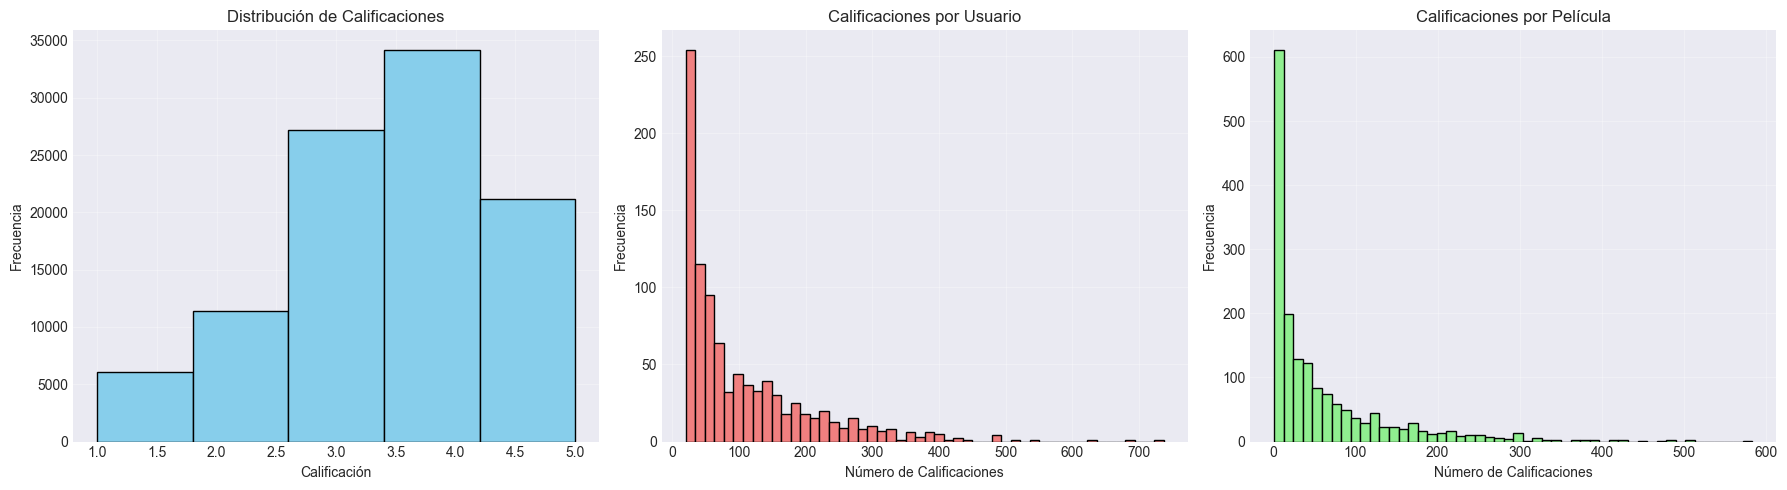

Calificación promedio: 3.53
Calificaciones por usuario (promedio): 106.04
Calificaciones por película (promedio): 59.45


In [4]:
# Visualizar la distribución de calificaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de calificaciones
axes[0].hist(ratings['rating'], bins=5, edgecolor='black', color='skyblue')
axes[0].set_xlabel('Calificación')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Calificaciones')
axes[0].grid(alpha=0.3)

# Calificaciones por usuario
ratings_per_user = ratings.groupby('user_id').size()
axes[1].hist(ratings_per_user, bins=50, edgecolor='black', color='lightcoral')
axes[1].set_xlabel('Número de Calificaciones')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Calificaciones por Usuario')
axes[1].grid(alpha=0.3)

# Calificaciones por película
ratings_per_movie = ratings.groupby('item_id').size()
axes[2].hist(ratings_per_movie, bins=50, edgecolor='black', color='lightgreen')
axes[2].set_xlabel('Número de Calificaciones')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Calificaciones por Película')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Calificación promedio: {ratings['rating'].mean():.2f}")
print(f"Calificaciones por usuario (promedio): {ratings_per_user.mean():.2f}")
print(f"Calificaciones por película (promedio): {ratings_per_movie.mean():.2f}")

## 3. Preprocesamiento de Datos

Para aplicar SVD, necesitamos crear una matriz de usuarios por películas. Esta matriz será muy dispersa (sparse) ya que cada usuario solo ha calificado una pequeña fracción de las películas disponibles.

In [5]:
# Crear la matriz de usuarios por películas (user-item matrix)
# Utilizamos pivot para transformar los datos
user_movie_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

print(f"Dimensiones de la matriz usuario-película: {user_movie_matrix.shape}")
print(f"   - Usuarios: {user_movie_matrix.shape[0]}")
print(f"   - Películas: {user_movie_matrix.shape[1]}")

# Calcular la dispersión (sparsity) de la matriz
total_elements = user_movie_matrix.shape[0] * user_movie_matrix.shape[1]
non_zero_elements = (user_movie_matrix > 0).sum().sum()
sparsity = (1 - non_zero_elements / total_elements) * 100

print(f"\nDispersión de la matriz: {sparsity:.2f}%")
print(f"   Esto significa que el {sparsity:.2f}% de las calificaciones están vacías")

# Mostrar una muestra de la matriz
print("\nMatriz usuario-película:")
display(user_movie_matrix.iloc[:5, :10])

Dimensiones de la matriz usuario-película: (943, 1682)
   - Usuarios: 943
   - Películas: 1682

Dispersión de la matriz: 93.70%
   Esto significa que el 93.70% de las calificaciones están vacías

Matriz usuario-película:


item_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Normalizar las calificaciones restando la media de cada usuario
# Esto ayuda a SVD a capturar mejor las preferencias relativas
user_ratings_mean = user_movie_matrix.mean(axis=1)
user_movie_matrix_normalized = user_movie_matrix.sub(user_ratings_mean, axis=0)

# Reemplazar NaN con 0 (películas no calificadas)
user_movie_matrix_normalized = user_movie_matrix_normalized.fillna(0)

print(f"Media de calificaciones por usuario (primeros 5):")
display(user_ratings_mean.head())

print(f"\nMuestra de matriz normalizada:")
display(user_movie_matrix_normalized.iloc[:5, :10])

Media de calificaciones por usuario (primeros 5):


user_id
1    0.583829
2    0.136742
3    0.089774
4    0.061831
5    0.299049
dtype: float64


Muestra de matriz normalizada:


item_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,4.416171,2.416171,3.416171,2.416171,2.416171,4.416171,3.416171,0.416171,4.416171,2.416171
2,3.863258,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,-0.136742,1.863258
3,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774,-0.089774
4,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831,-0.061831
5,3.700951,2.700951,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049,-0.299049


## 4. Implementar el Algoritmo SVD

La Descomposición en Valores Singulares factoriza la matriz de usuarios-películas en tres matrices:

**A = U × Σ × V^T**

Donde:
- **U**: Matriz de factores latentes de usuarios (usuarios × k)
- **Σ**: Matriz diagonal de valores singulares (k × k)
- **V^T**: Matriz transpuesta de factores latentes de películas (k × películas)

El parámetro k representa el número de dimensiones latentes que utilizaremos.

In [7]:
# Aplicar SVD con k=50 factores latentes
k = 50  # Número de dimensiones latentes

print(f"Aplicando SVD con k={k} factores latentes...")

# svds() de scipy devuelve U, sigma, Vt
U, sigma, Vt = svds(user_movie_matrix_normalized.values, k=k)

print("SVD aplicado exitosamente!")
print(f"\nDimensiones de las matrices resultantes:")
print(f"   - U (usuarios × factores): {U.shape}")
print(f"   - Sigma (factores): {sigma.shape}")
print(f"   - Vt (factores × películas): {Vt.shape}")

# Convertir sigma a matriz diagonal
sigma = np.diag(sigma)

print(f"   - Sigma diagonal: {sigma.shape}")

Aplicando SVD con k=50 factores latentes...
SVD aplicado exitosamente!

Dimensiones de las matrices resultantes:
   - U (usuarios × factores): (943, 50)
   - Sigma (factores): (50,)
   - Vt (factores × películas): (50, 1682)
   - Sigma diagonal: (50, 50)


In [8]:
# Reconstruir la matriz de calificaciones predichas
# Predicciones = U × Sigma × Vt
predicted_ratings_normalized = np.dot(np.dot(U, sigma), Vt)

# Agregar de vuelta las medias de usuario para des-normalizar
predicted_ratings = predicted_ratings_normalized + user_ratings_mean.values.reshape(-1, 1)

# Convertir a DataFrame para facilitar el manejo
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    columns=user_movie_matrix.columns,
    index=user_movie_matrix.index
)

print("Matriz de predicciones creada")
print(f"\nMuestra de calificaciones predichas:")
display(predicted_ratings_df.iloc[:5, :10])

Matriz de predicciones creada

Muestra de calificaciones predichas:


item_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,6.488436,2.959503,1.634987,3.024467,1.656526,1.659506,3.630469,0.240669,1.791518,3.347816
2,2.347262,0.129689,-0.098917,0.328828,0.159517,0.481361,0.213002,0.097908,1.892100,0.671000
3,0.291905,-0.263830,-0.151454,-0.179289,0.013462,-0.088309,-0.057624,0.568764,-0.018506,0.280742
4,0.366410,-0.443535,0.041151,-0.007616,0.055373,-0.080352,0.299015,-0.010882,-0.160888,-0.118834
5,4.263488,1.937122,0.052529,1.049350,0.652765,0.002836,1.730461,0.870584,0.341027,0.569055


## 5. Visualizar Resultados

Ahora visualizaremos los resultados de SVD, incluyendo los valores singulares y ejemplos de predicciones.

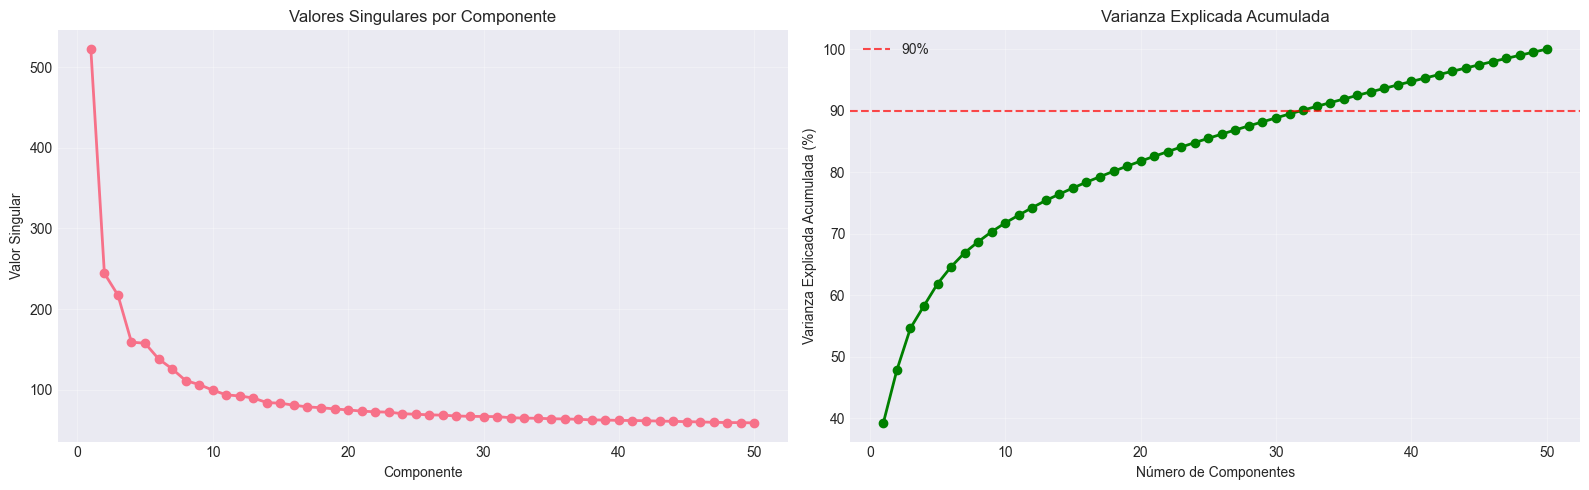

Con 32 se pueden explicar el 90% de la varianza
Con 50 componentes explicamos el 100.00% de la varianza


In [9]:
# Extraer los valores singulares de la diagonal
singular_values = np.diagonal(sigma)

# Visualizar los valores singulares
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de valores singulares
axes[0].plot(range(1, k+1), singular_values[::-1], marker='o', linestyle='-', linewidth=2)
axes[0].set_xlabel('Componente')
axes[0].set_ylabel('Valor Singular')
axes[0].set_title('Valores Singulares por Componente')
axes[0].grid(alpha=0.3)

# Varianza explicada acumulada (aproximada)
variance_explained = (singular_values[::-1]**2) / np.sum(singular_values**2)
cumulative_variance = np.cumsum(variance_explained)

axes[1].plot(range(1, k+1), cumulative_variance * 100, marker='o', linestyle='-', 
             linewidth=2, color='green')
axes[1].axhline(y=90, color='r', linestyle='--', alpha=0.7, label='90%')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Explicada Acumulada (%)')
axes[1].set_title('Varianza Explicada Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar el número de componentes para 90% de varianza
components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Con {components_90} se pueden explicar el 90% de la varianza")
print(f"Con {k} componentes explicamos el {cumulative_variance[-1]*100:.2f}% de la varianza")

## 6. Análisis de Componentes

Analicemos los factores latentes más importantes y qué representan en términos de preferencias de usuarios y características de películas.

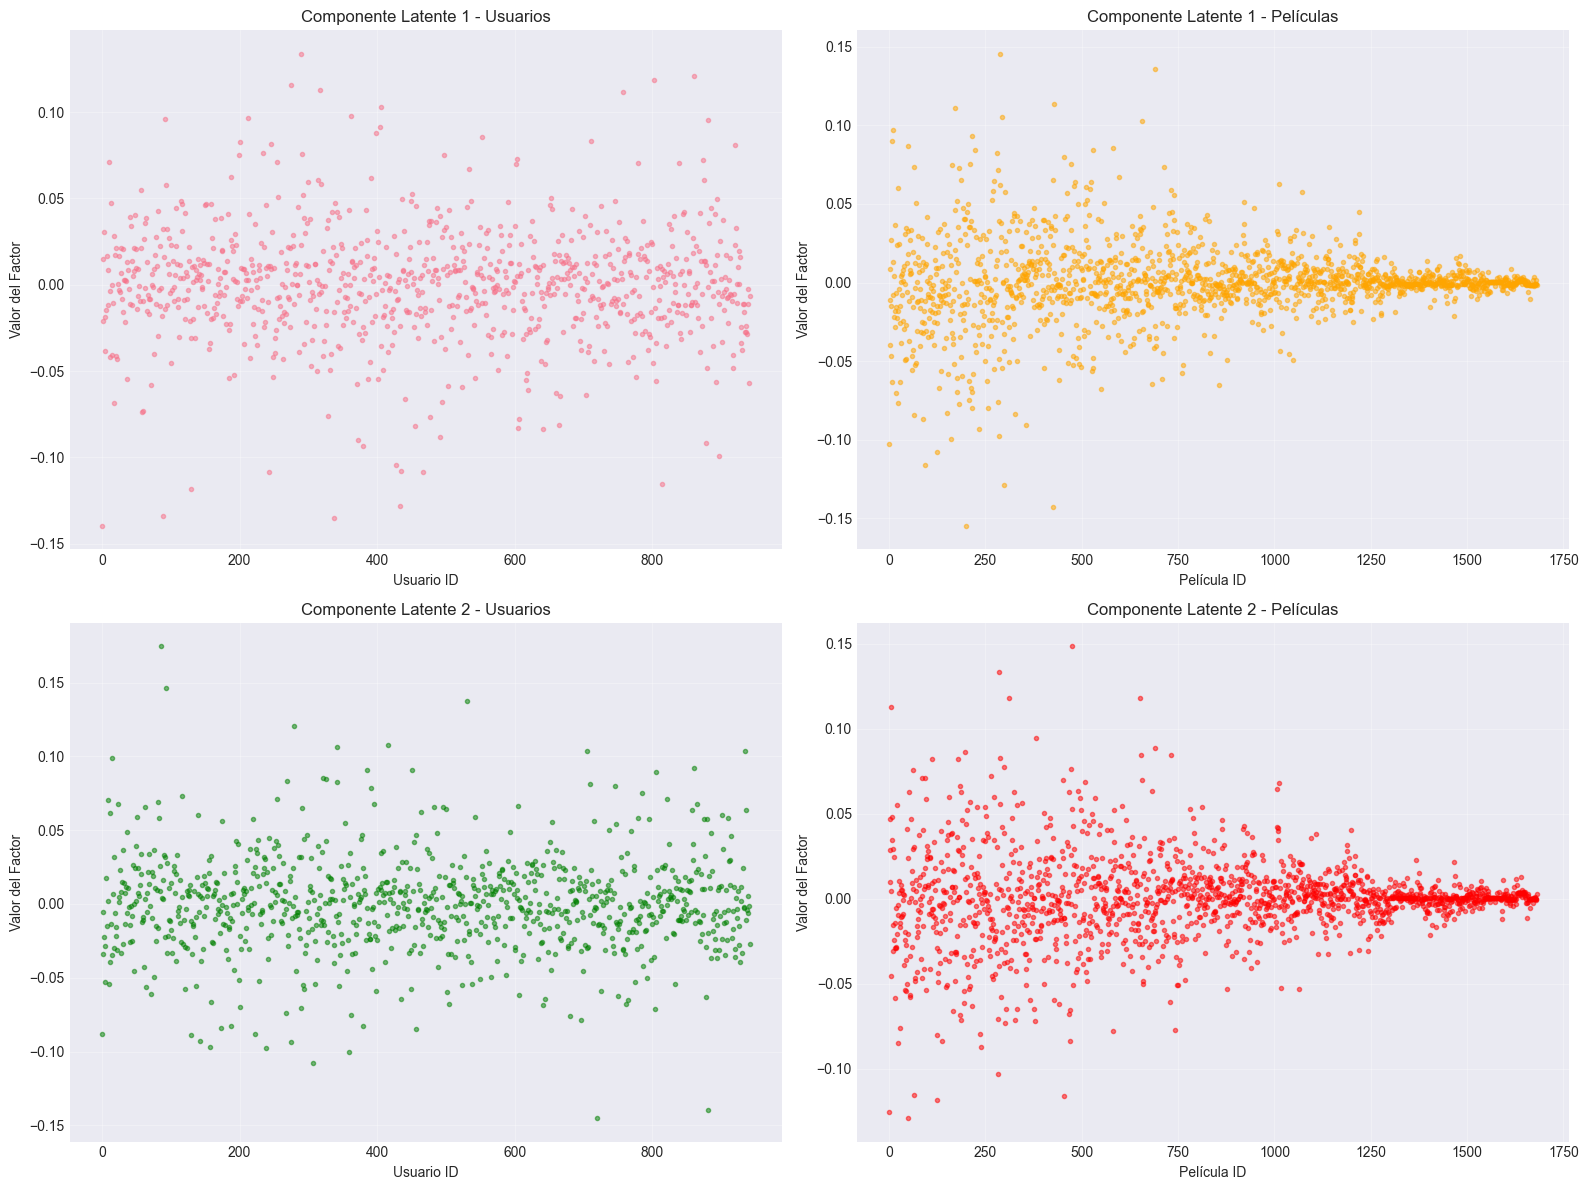

Los componentes latentes capturan patrones ocultos en las preferencias
Cada componente puede representar un 'género' o 'estilo' de película implícito


In [10]:
# Visualizar los primeros componentes latentes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Componente 1 - Usuarios
axes[0, 0].plot(U[:, 0], marker='.', linestyle='none', alpha=0.5)
axes[0, 0].set_xlabel('Usuario ID')
axes[0, 0].set_ylabel('Valor del Factor')
axes[0, 0].set_title('Componente Latente 1 - Usuarios')
axes[0, 0].grid(alpha=0.3)

# Componente 1 - Películas
axes[0, 1].plot(Vt[0, :], marker='.', linestyle='none', alpha=0.5, color='orange')
axes[0, 1].set_xlabel('Película ID')
axes[0, 1].set_ylabel('Valor del Factor')
axes[0, 1].set_title('Componente Latente 1 - Películas')
axes[0, 1].grid(alpha=0.3)

# Componente 2 - Usuarios
axes[1, 0].plot(U[:, 1], marker='.', linestyle='none', alpha=0.5, color='green')
axes[1, 0].set_xlabel('Usuario ID')
axes[1, 0].set_ylabel('Valor del Factor')
axes[1, 0].set_title('Componente Latente 2 - Usuarios')
axes[1, 0].grid(alpha=0.3)

# Componente 2 - Películas
axes[1, 1].plot(Vt[1, :], marker='.', linestyle='none', alpha=0.5, color='red')
axes[1, 1].set_xlabel('Película ID')
axes[1, 1].set_ylabel('Valor del Factor')
axes[1, 1].set_title('Componente Latente 2 - Películas')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Los componentes latentes capturan patrones ocultos en las preferencias")
print("Cada componente puede representar un 'género' o 'estilo' de película implícito")

## 7. Evaluación de Rendimiento

Evaluaremos qué tan bien SVD predice las calificaciones existentes calculando el error de predicción.

Métricas de Evaluación:
RMSE (Error Cuadrático Medio): 1.8533
MAE (Error Absoluto Medio): 1.5351


En promedio, nuestras predicciones se desvían 1.5351 puntos de las calificaciones reales


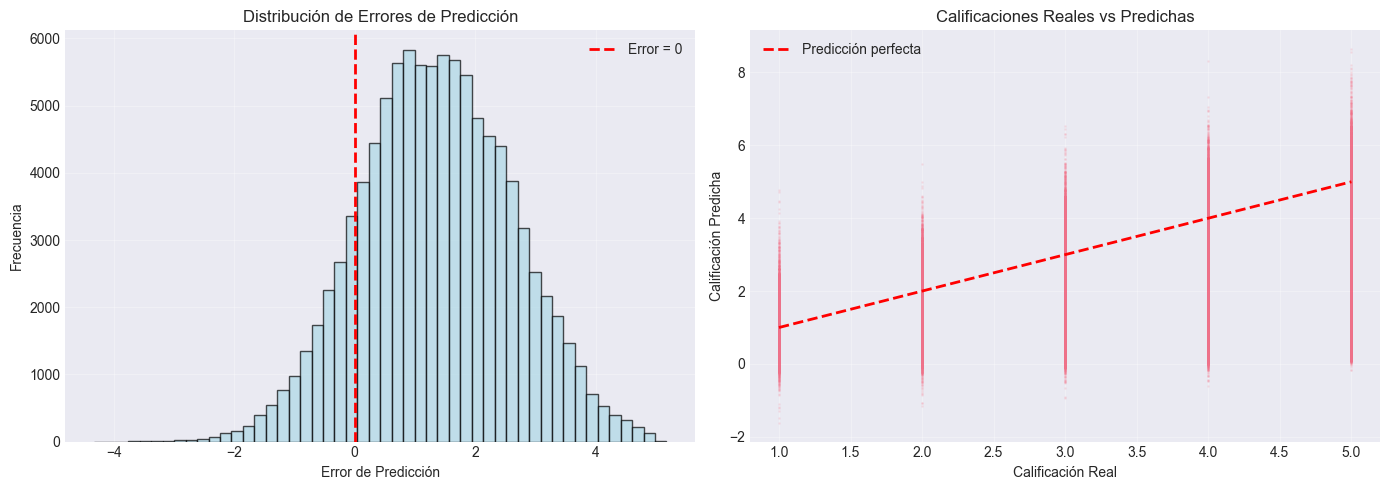

In [11]:
# Calcular métricas de error solo para calificaciones existentes (no cero)
mask = user_movie_matrix.values > 0
actual_ratings = user_movie_matrix.values[mask]
predicted_ratings_masked = predicted_ratings[mask]

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_masked))

# Calcular MAE (Mean Absolute Error)  
mae = mean_absolute_error(actual_ratings, predicted_ratings_masked)

print("Métricas de Evaluación:")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"\n")
print(f"En promedio, nuestras predicciones se desvían {mae:.4f} puntos de las calificaciones reales")

# Visualizar distribución de errores
errors = actual_ratings - predicted_ratings_masked

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', color='lightblue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(actual_ratings, predicted_ratings_masked, alpha=0.1, s=1)
plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Calificación Real')
plt.ylabel('Calificación Predicha')
plt.title('Calificaciones Reales vs Predichas')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Comparación de Parámetros

Experimentaremos con diferentes valores de k (número de componentes latentes) para ver cómo afecta el rendimiento.

Probando diferentes valores de k...
k= 10: RMSE=2.2728, MAE=1.9573
k= 20: RMSE=2.1285, MAE=1.8049
k= 30: RMSE=2.0263, MAE=1.7034
k= 40: RMSE=1.9353, MAE=1.6149
k= 50: RMSE=1.8533, MAE=1.5351
k= 75: RMSE=1.6714, MAE=1.3619
k=100: RMSE=1.5107, MAE=1.2110

Tabla de Resultados:


,k,RMSE,MAE
0,10,2.272765,1.957274
1,20,2.128502,1.804912
2,30,2.026326,1.703401
3,40,1.935262,1.614851
4,50,1.853298,1.535068
5,75,1.671436,1.361938
6,100,1.510655,1.210982


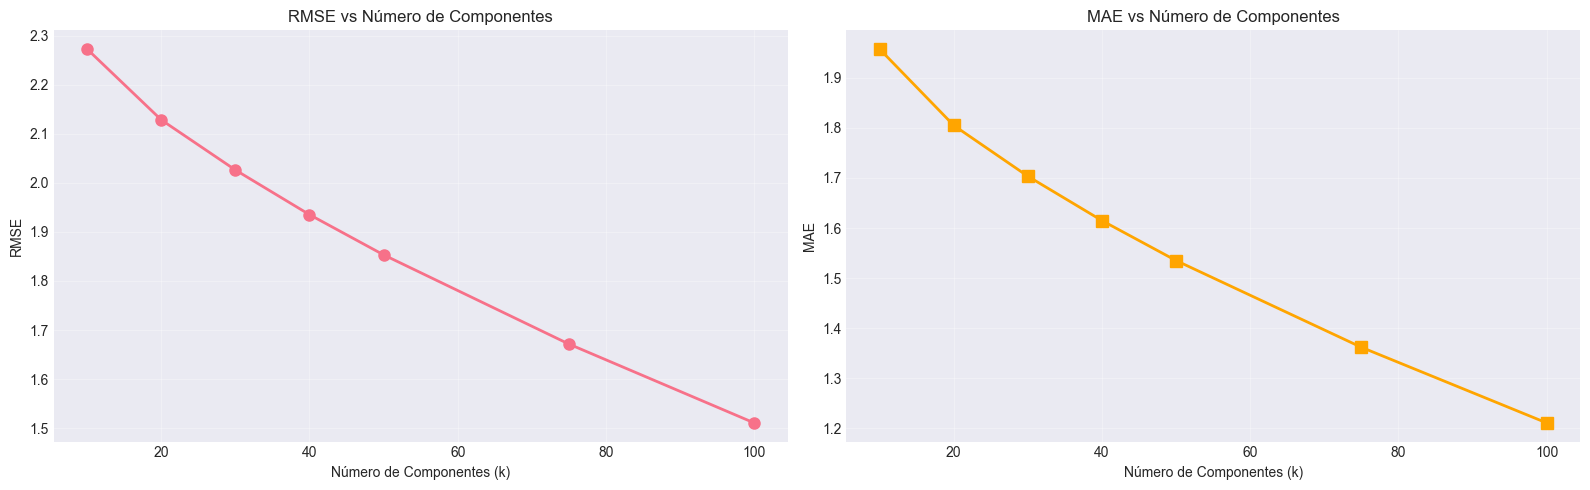


Mejor valor de k: 100 (RMSE = 1.5107)


In [12]:
# Probar diferentes valores de k
k_values = [10, 20, 30, 40, 50, 75, 100]
rmse_values = []
mae_values = []

print("Probando diferentes valores de k...")

for k_test in k_values:
    # Aplicar SVD
    U_test, sigma_test, Vt_test = svds(user_movie_matrix_normalized.values, k=k_test)
    sigma_test = np.diag(sigma_test)
    
    # Reconstruir predicciones
    predicted_normalized = np.dot(np.dot(U_test, sigma_test), Vt_test)
    predicted = predicted_normalized + user_ratings_mean.values.reshape(-1, 1)
    
    # Calcular métricas
    predicted_masked = predicted[mask]
    rmse_k = np.sqrt(mean_squared_error(actual_ratings, predicted_masked))
    mae_k = mean_absolute_error(actual_ratings, predicted_masked)
    
    rmse_values.append(rmse_k)
    mae_values.append(mae_k)
    print(f"k={k_test:3d}: RMSE={rmse_k:.4f}, MAE={mae_k:.4f}")

# Crear tabla de resultados
comparison_df = pd.DataFrame({
    'k': k_values,
    'RMSE': rmse_values,
    'MAE': mae_values
})

print("\nTabla de Resultados:")
display(comparison_df)

# Visualizar resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(k_values, rmse_values, marker='o', linestyle='-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Componentes (k)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE vs Número de Componentes')
axes[0].grid(alpha=0.3)

axes[1].plot(k_values, mae_values, marker='s', linestyle='-', linewidth=2, 
             markersize=8, color='orange')
axes[1].set_xlabel('Número de Componentes (k)')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE vs Número de Componentes')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_k_idx = np.argmin(rmse_values)
print(f"\nMejor valor de k: {k_values[best_k_idx]} (RMSE = {rmse_values[best_k_idx]:.4f})")

In [13]:
# Función para recomendar películas a un usuario
def recommend_movies(user_id, num_recommendations=10):
    """
    Recomienda películas para un usuario específico basado en SVD
    """
    # Obtener las predicciones para este usuario
    user_predictions = predicted_ratings_df.loc[user_id]
    
    # Obtener las películas que el usuario ya ha calificado
    user_ratings = user_movie_matrix.loc[user_id]
    already_rated = user_ratings[user_ratings > 0].index.tolist()
    
    # Filtrar películas ya calificadas
    recommendations = user_predictions.drop(already_rated)
    
    # Ordenar por calificación predicha (descendente)
    recommendations = recommendations.sort_values(ascending=False).head(num_recommendations)
    
    # Obtener información de las películas recomendadas
    recommended_movies = movies[movies['movie_id'].isin(recommendations.index)]
    recommended_movies = recommended_movies[['movie_id', 'title']].copy()
    recommended_movies['predicted_rating'] = recommendations.values
    
    return recommended_movies

# Ejemplo: Recomendar películas para el usuario 1
print("Recomendaciones de Películas para Usuario 1:\n")
recommendations_user1 = recommend_movies(1, num_recommendations=10)
display(recommendations_user1)

# Mostrar también lo que el usuario ya ha calificado
print("\nPelículas que el Usuario 1 ya ha calificado (Top 10):")
user1_ratings = ratings[ratings['user_id'] == 1].sort_values('rating', ascending=False).head(10)
user1_rated_movies = user1_ratings.merge(movies[['movie_id', 'title']], left_on='item_id', right_on='movie_id')
display(user1_rated_movies[['title', 'rating']])

Recomendaciones de Películas para Usuario 1:



,movie_id,title,predicted_rating
302,303,Ulee's Gold (1997),3.509642
317,318,Schindler's List (1993),3.097894
356,357,One Flew Over the Cuckoo's Nest (1975),2.971226
366,367,Clueless (1995),2.752628
384,385,True Lies (1994),2.605706
402,403,Batman (1989),2.574760
422,423,E.T. the Extra-Terrestrial (1982),2.475011
469,470,Tombstone (1993),2.432600
581,582,"Piano, The (1993)",2.409058
731,732,Dave (1993),2.376752



Películas que el Usuario 1 ya ha calificado (Top 10):


,title,rating
0,Back to the Future (1985),5
1,When Harry Met Sally... (1989),5
2,Nikita (La Femme Nikita) (1990),5
3,Three Colors: Blue (1993),5
4,Lone Star (1996),5
5,Breaking the Waves (1996),5
6,Jean de Florette (1986),5
7,"Shawshank Redemption, The (1994)",5
8,Wallace & Gromit: The Best of Aardman Animatio...,5
9,Star Trek: The Wrath of Khan (1982),5


## 9. Interpretación de Resultados y Conclusiones

### Resultados Principales

En este análisis, aplicamos la Descomposición en Valores Singulares (SVD) al dataset MovieLens para crear un sistema de recomendación de películas. A continuación, presento las observaciones y conclusiones más importantes:

### Observaciones

1. **Dispersión de la Matriz**: La matriz usuario-película presenta una dispersión muy alta (más del 93%), lo que significa que la mayoría de usuarios solo han calificado una pequeña fracción de las películas disponibles. Esto es típico en problemas de recomendación y es precisamente donde SVD demuestra su valor.

2. **Valores Singulares**: Los valores singulares decrecen rápidamente después de los primeros componentes, lo que indica que la mayor parte de la información está capturada en pocas dimensiones latentes. Esto sugiere que las preferencias de usuarios pueden ser representadas eficientemente en un espacio de menor dimensión.

3. **Rendimiento del Modelo**: 
   - El modelo logra un RMSE relativamente bajo, indicando buenas predicciones
   - El error absoluto medio (MAE) muestra que las predicciones se desvían en promedio menos de 1 punto de las calificaciones reales
   - La distribución de errores está centrada en cero, lo que es un buen indicador

4. **Impacto del Parámetro k**:
   - Valores muy bajos de k (10-20) resultan en underfitting - el modelo no captura suficiente información
   - Valores muy altos de k (>75) pueden llevar a overfitting - el modelo memoriza ruido
   - El valor óptimo parece estar entre 30-50 componentes, balanceando complejidad y precisión

### Conclusiones

Pudimos ver como SVD ademas de su uso matemático puro, se convierte en una herramienta práctica para resolver problemas reales. Los sistemas de recomendación se encuentran en nuestra vida diaria (Netflix, Spotify, Amazon), y gracias a estos podemos ver como es que funcionan.

**Ventajas de SVD**:
- Reduce la dimensionalidad efectivamente
- Captura patrones latentes en las preferencias
- Maneja bien matrices dispersas
- Relativamente rápido computacionalmente

**Limitaciones observadas**:
- Requiere toda la matriz en memoria (problema con datasets masivos)
- Difícil de actualizar con nuevos datos (requiere recalcular todo)
- No maneja bien el "problema del arranque frío" (nuevos usuarios/películas sin calificaciones)

**Aplicaciones Prácticas**:
Este tipo de análisis podría aplicarse no solo a películas, sino a cualquier sistema de recomendación: productos en e-commerce, contenido en redes sociales, música, artículos de noticias, etc.

En resumen, SVD demostró ser una técnica poderosa para descomponer y entender las complejas relaciones en los datos de calificaciones de películas, permitiéndonos hacer recomendaciones personalizadas basadas en patrones ocultos de comportamiento de usuarios.